In [72]:
import torch
import torchvision
import torchmetrics
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import random

import pathlib
import zipfile
import requests
import os

from PIL import Image

> ### Getting a dataset (Food 101)
+ The Food-101 dataset consists of 101 food categories with 750 training and 250 test images per category, making a total of 101k images.<br><br>
+ On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels.<br><br>
+ All images were rescaled to have a maximum side length of 512 pixels.<br><br>
+ We will download a small subset of Food101 data and 1000 images per class<br><br>
+ Our small dataset will have only 3 classes of food (Pizza, Steak and Sushi) and will have only 10% of the images in the original dataset.

> #### Downloading the data

In [3]:
data_path = pathlib.Path('data/')

image_path = data_path / 'pizza_steak_sushi/'

if image_path.is_dir():
    print(f'{image_path} directory already exists. Data will not be downloaded again.')

else:
    print(f'The directory ({image_path}) does not exists. New directory created.')
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
        print('Downloading a small subset (zipfile) of Food-101 dataset . . . ')
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
        f.write(request.content)
    
    with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
        print('Unzipping data.')
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists. Data will not be downloaded again.


> #### Visualizing some random images

In [4]:
image_paths_list = list(image_path.glob('*/*/*.jpg'))

train_path = image_path / 'train'
test_path = image_path / 'test'

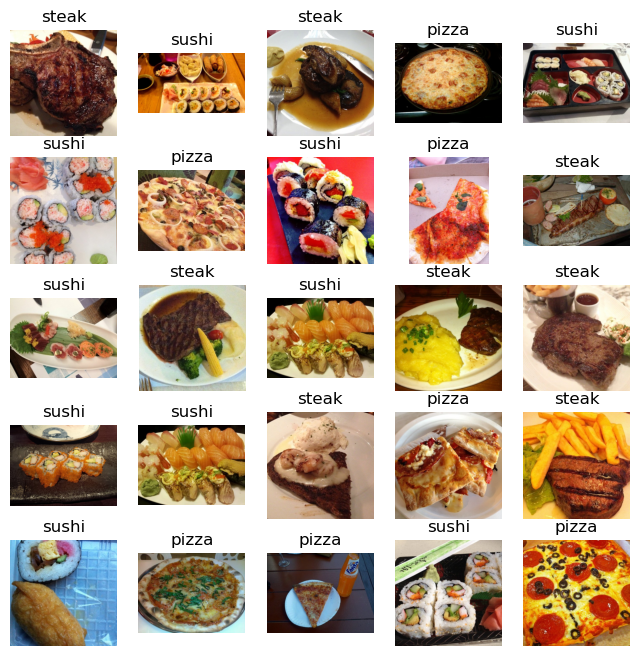

In [5]:
torch.manual_seed(42)
fig = plt.figure(figsize=(8, 8))
rows , cols = 5, 5

for i in range(1, rows * cols + 1):
    random_image_path = random.choice(image_paths_list)
    image_arr = np.asarray(Image.open(random_image_path))
    label = random_image_path.parent.stem
    fig.add_subplot(rows, cols, i)
    plt.imshow(image_arr, cmap='gray')
    plt.title(label)
    plt.axis('off')

> #### Transforming images into Tensors

In [6]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_data_simple = torchvision.datasets.ImageFolder(root=train_path,
                                              transform=simple_transform,
                                              target_transform=None)

test_data_simple = torchvision.datasets.ImageFolder(root=test_path,
                                             transform=simple_transform,
                                             target_transform=None)

In [8]:
train_data_simple.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [42]:
def load_data(data, BATCH_SIZE):
    return torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

In [155]:
def train_and_evaluate_model(model, loss_fn, optimizer, tr_data, ts_data,
                             epochs, batch_size):
    tr_losses = []
    tr_accuracies = []
    
    ts_losses = []
    ts_accuracies = []
    
    tr_dataloader = load_data(tr_data, batch_size)
    ts_dataloader = load_data(ts_data, batch_size)
    
    for epoch in range(epochs):
        model.train()
        tr_loss = 0
        tr_accuracy = 0
        for tr_X, tr_y in tr_dataloader:
            tr_predictions = model(tr_X)
            loss = loss_fn(tr_predictions, tr_y)
            tr_loss += loss.item()
            tr_predictions = torch.argmax(torch.softmax(tr_predictions, dim=1), dim=1)
            tr_accuracy += accuracy(tr_predictions, tr_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        tr_accuracy /= len(tr_dataloader)
        tr_loss /= len(tr_dataloader)
        tr_losses.append(tr_loss)
        tr_accuracies.append(tr_accuracy)
        
        with torch.no_grad():
            ts_loss = 0
            ts_accuracy = 0
            
            for ts_X, ts_y in ts_dataloader:
                ts_predictions = model(ts_X)
                loss  = loss_fn(ts_predictions, ts_y)
                ts_loss += loss.item()
                ts_predictions = torch.argmax(torch.softmax(ts_predictions, dim=1), dim=1)
                ts_accuracy += accuracy(ts_predictions, ts_y)
            ts_accuracy /= (len(ts_dataloader))
            ts_loss /= len(ts_dataloader)
            ts_losses.append(ts_loss)
            ts_accuracies.append(ts_accuracy)
        
        print(f"Epoch: {epoch + 1:2d} | tr_loss: {tr_loss:.4f} | ts_loss: {ts_loss:.4f} |  tr_acc: {tr_accuracy:.4f} | ts_acc: {ts_accuracy:.4f} |")
        
    return {
        "trained_model": type(model).__name__,
        "tr_losses": tr_losses,
        "tr_accuracies": tr_accuracies,
        "ts_losses": ts_losses,
        "ts_accuracies": ts_accuracies
    }

In [156]:
def plot_results(model_results):
    tr_loss = model_results['tr_losses']
    ts_loss = model_results['ts_losses']
    
    tr_accuracies = model_results['tr_accuracies']
    ts_accuracies = model_results['ts_accuracies']
    
    epochs = range(len(tr_accuracies))
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, label='train_loss')
    plt.plot(epochs, ts_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_accuracies, label='train_accuracy')
    plt.plot(epochs, ts_accuracies, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

> ### Tiny VGG Model (without data augmentation)

In [157]:
class Food_101_TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_units):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),            
            nn.ReLU(),            
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),            
            nn.ReLU(),            
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block_2 = nn.Sequential(            
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),            
            nn.ReLU(),            
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),            
            nn.ReLU(),            
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * (13 * 13), out_features=3)
        )
    
    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [173]:
EPOCHS = 5
BATCH_SIZE = 32
learning_rate = 0.001

model_tiny_vgg = Food_101_TinyVGG(input_shape=3, hidden_units=128)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tiny_vgg.parameters(), lr=learning_rate)

In [174]:
model_results = train_and_evaluate_model(model_tiny_vgg, loss_fn, optimizer,
                                         train_data_simple, test_data_simple,
                                         EPOCHS, BATCH_SIZE)

Epoch:  1 | tr_loss: 1.1111 | ts_loss: 1.1025 |  tr_acc: 0.2695 | ts_acc: 0.4848 |
Epoch:  2 | tr_loss: 1.0452 | ts_loss: 1.0244 |  tr_acc: 0.5000 | ts_acc: 0.4830 |
Epoch:  3 | tr_loss: 1.0147 | ts_loss: 1.0181 |  tr_acc: 0.3906 | ts_acc: 0.3419 |
Epoch:  4 | tr_loss: 1.0022 | ts_loss: 0.9618 |  tr_acc: 0.5039 | ts_acc: 0.5246 |
Epoch:  5 | tr_loss: 0.9235 | ts_loss: 1.0362 |  tr_acc: 0.6094 | ts_acc: 0.5256 |


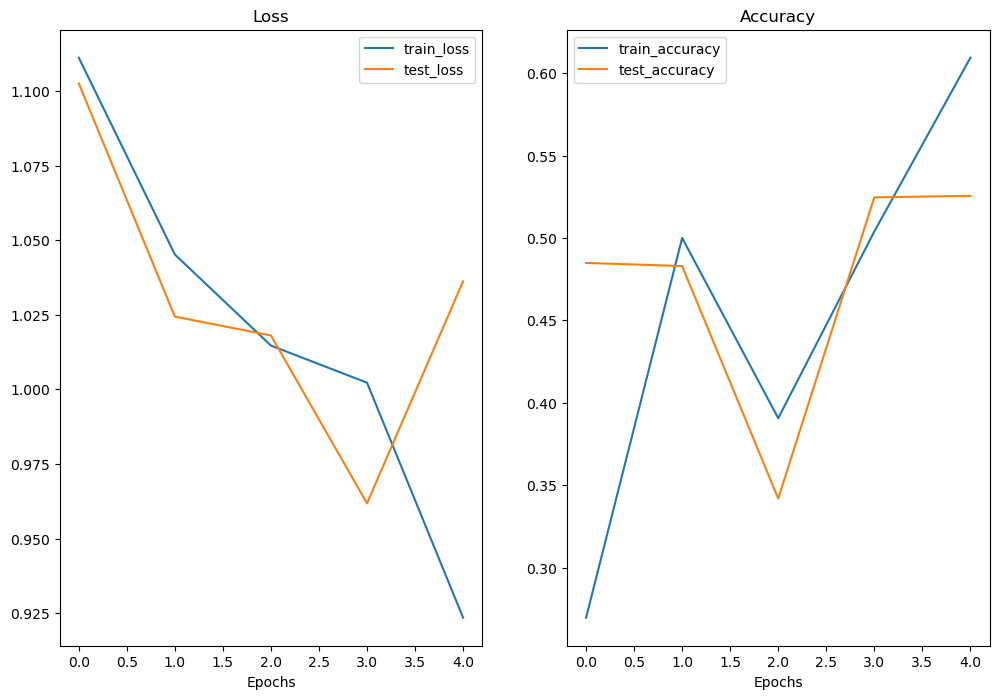

In [175]:
plot_results(model_results)

> #### Data Augmentation

In [166]:
aug_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

train_data_aug = torchvision.datasets.ImageFolder(root=train_path,
                                                  transform=aug_transform,
                                                  target_transform=None)

In [167]:
model_tiny_vgg = Food_101_TinyVGG(input_shape=3, hidden_units=10)

model_results = train_and_evaluate_model(model_tiny_vgg, loss_fn, optimizer,
                                         train_data_aug, test_data_simple,
                                         EPOCHS, BATCH_SIZE)

Epoch:  1 | tr_loss: 1.1049 | ts_loss: 1.0989 |  tr_acc: 0.2930 | ts_acc: 0.2178 |
Epoch:  2 | tr_loss: 1.0956 | ts_loss: 1.1013 |  tr_acc: 0.4141 | ts_acc: 0.2377 |
Epoch:  3 | tr_loss: 1.1051 | ts_loss: 1.1028 |  tr_acc: 0.2930 | ts_acc: 0.2178 |
Epoch:  4 | tr_loss: 1.0955 | ts_loss: 1.1015 |  tr_acc: 0.4141 | ts_acc: 0.2576 |
Epoch:  5 | tr_loss: 1.0992 | ts_loss: 1.1018 |  tr_acc: 0.2930 | ts_acc: 0.2576 |
